In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

root_dir = '/content/gdrive/MyDrive/Data'

Mounted at /content/gdrive


In [2]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from pandas.core.frame import DataFrame
from time import sleep


Downsampling preprocessing's dataset

In [ ]:
data_loading_dir = os.path.join(root_dir, "18 participants/AX3/Preprocessed")
experience = 10
data_saving_dir = os.path.join(root_dir, "18 participants/AX3/DownsampledDataset"+str(experience))

div = 1000
portion = int(3000 / div)
sections = []
for i in range(0, 3000, portion):
  sections.append(i)
sections.append(3000)
print(sections)

def downsample(dataset):
  newDataset = pd.DataFrame()
  newDataset["Label"] = dataset["Label"]
  for i in range(div):
    newDataset["X" + str(i)] = dataset["X"].apply(lambda x : np.mean(np.array(x[sections[i]:sections[i+1]])))
    newDataset["Y" + str(i)] = dataset["Y"].apply(lambda x : np.mean(np.array(x[sections[i]:sections[i+1]])))
    newDataset["Z" + str(i)] = dataset["Z"].apply(lambda x : np.mean(np.array(x[sections[i]:sections[i+1]])))
  newDataset["Temp"] = dataset["Temp"].apply(lambda x : np.mean(np.array(x)))
  newDataset["Activity"] = dataset["Activity"]
  dataset = None
  sleep(60)
  return newDataset

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156, 159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192, 195, 198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231, 234, 237, 240, 243, 246, 249, 252, 255, 258, 261, 264, 267, 270, 273, 276, 279, 282, 285, 288, 291, 294, 297, 300, 303, 306, 309, 312, 315, 318, 321, 324, 327, 330, 333, 336, 339, 342, 345, 348, 351, 354, 357, 360, 363, 366, 369, 372, 375, 378, 381, 384, 387, 390, 393, 396, 399, 402, 405, 408, 411, 414, 417, 420, 423, 426, 429, 432, 435, 438, 441, 444, 447, 450, 453, 456, 459, 462, 465, 468, 471, 474, 477, 480, 483, 486, 489, 492, 495, 498, 501, 504, 507, 510, 513, 516, 519, 522, 525, 528, 531, 534, 537, 540, 543, 546, 549, 552, 555, 558, 561, 564, 567, 570, 573, 576, 579, 582, 585, 588, 591, 594, 597, 600, 603, 606, 609, 612, 615, 618, 62

In [ ]:
participants = 1

if not os.path.exists(data_saving_dir):
  os.mkdir(data_saving_dir)

for participant in range(1, participants+1):
  file_name = os.path.join(data_loading_dir, "AX3_step1_sub" + str(participant) + ".pkl")
  save_name = os.path.join(data_saving_dir, "Dataset_participant" + str(participant) + ".pkl")
  dataset = pd.read_pickle(file_name)
  ratio = 0.5
  print(int(dataset.shape[0]*ratio))
  print(dataset[int(dataset.shape[0]*ratio):].shape)
  newDataset = downsample(dataset[int(dataset.shape[0]*ratio):])
  newDataset.to_pickle(save_name)
  dataset = None
  sleep(60)


14810
(14810, 8)


<ipython-input-18-7be74feefa4a>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  newDataset["X" + str(i)] = dataset["X"].apply(lambda x : np.mean(np.array(x[sections[i]:sections[i+1]])))
<ipython-input-18-7be74feefa4a>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  newDataset["Y" + str(i)] = dataset["Y"].apply(lambda x : np.mean(np.array(x[sections[i]:sections[i+1]])))
<ipython-input-18-7be74feefa4a>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

Data transformation

In [ ]:
experience = 10
data_loading_dir = os.path.join(root_dir, "18 participants/AX3/DownsampledDataset" + str(experience))
file_name = os.path.join(data_loading_dir, "Dataset_participant1.pkl")
participants = 1
orig_dataset = pd.read_pickle(file_name)

for participant in range(2, participants + 1):
  file_name = os.path.join(data_loading_dir, "Dataset_participant" + str(participant) + ".pkl")
  new_dataset = pd.read_pickle(file_name)
  orig_dataset = orig_dataset.append(new_dataset, ignore_index=True)

data_saving_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
if not os.path.exists(data_saving_dir):
  os.mkdir(data_saving_dir)

save_file = os.path.join(data_saving_dir, "Raw.pkl")
orig_dataset.to_pickle(save_file)

In [3]:
from scipy.fft import fft

def perm(orig_dataset):
  dataset = orig_dataset.drop(['Label'], axis=1)
  columns = np.array(dataset.columns)
  randIdx = random.sample(range(0, len(columns)),len(columns))
  new_columns = []
  for i in range(len(columns)):
    new_columns.append(columns[randIdx[i]])
  dataset.columns = (new_columns)
  for i in range(len(columns)):
    column = new_columns[i]
    dataset[column] = orig_dataset[column]
  return dataset

def noise(orig_dataset):
  dataset = orig_dataset.drop(['Label'], axis=1)
  stds = np.array(orig_dataset.std())
  #print(orig_dataset.std())
  #print(stds)
  columns = dataset.columns
  #print(len(columns))
  #print(len(stds))
  for i in range(len(columns)):
    std_val = stds[i] 
    column = columns[i]
    mean = dataset[column].mean()
    res = np.array(np.random.normal(mean, std_val, (orig_dataset.shape[0],)))
    dataset['std'] = res
    #print(str(mean)+','+str(std_val)+','+str(dataset['std'].head(2)))
    #print(res)
    dataset[column] = dataset[column] + dataset['std']
  dataset = dataset.drop(['std'], axis=1)
  #print(dataset.head(3))
  return dataset

def FFT(orig_dataset):
  dataset = orig_dataset.drop(['Label'], axis=1)
  columns = dataset.columns
  for i in range(len(columns)):
    column = columns[i]
    dataset[column] = fft(np.array(dataset[column]))
  return dataset

def scale(orig_dataset):
  dataset = orig_dataset.drop(['Label'], axis=1)
  columns = dataset.columns
  for column in columns:
    dataset.loc[:, column] *= 1.5
  return dataset

def negation(orig_dataset):
  dataset = orig_dataset.drop(['Label'], axis=1)
  columns = dataset.columns
  for column in columns:
    dataset.loc[:, column] *= -1
  return dataset

def negation_plus_noise(orig_dataset):
  negated_dataset = negation(orig_dataset)
  noised_dataset = noise(orig_dataset)
  dataset = orig_dataset.drop(['Label'], axis=1)
  columns = dataset.columns
  for column in columns:
    dataset[column] = negated_dataset[column] + noised_dataset[column]
  return dataset

def getLabel(label, length):
  data = {}
  for i in range(len(label)):
    data[i] = np.full(length,label[i])
  dataset = DataFrame(data)
  return dataset

def countNans(dataset):
  counts = 0
  columns = dataset.columns
  for i in range(len(columns)):
    column = columns[i]
    counts = counts + dataset[column].isnull().sum()
  return counts

def getLabelsDataset(numberOfClasses, length):
  label = np.zeros(numberOfClasses)
  label[0] = 1
  dataset = getLabel(label, length)
  for i in range(1, numberOfClasses):
    label = np.zeros(numberOfClasses)
    label[i] = 1
    new_dataset = getLabel(label, length)
    dataset = dataset.append(new_dataset, ignore_index=True)
    new_dataset = None
  return dataset

def windowDataset(dataset, window_size):
  new_dataset = []
  for i in range(0,dataset.shape[0], window_size):
    value = dataset[i]
    for j in range(i+1, i+window_size):
      value = np.append(value, dataset[j], axis=0)
    new_dataset.append(value)
  return np.array(new_dataset)

def windowLabels(dataset, window_size):
  new_labels = []
  for i in range(0, labels.shape[0], window_size):
    new_labels.append(labels[i])
  return np.array(new_labels)

def get_train_test_splits(dataset, spare_label, numberOfClasses):
  label = np.zeros(numberOfClasses)
  label[spare_label] = 1
  labels = getLabel(label, dataset.shape[0])
  dataset = np.array(dataset)
  n = dataset.shape[0]
  train_ratio = 0.9
  separate_id = int(n * train_ratio)

  x_train = dataset[:separate_id]
  y_train = labels[:separate_id]

  x_test = dataset[separate_id:]
  y_test = labels[separate_id:]
  return x_train, y_train, x_test, y_test

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
from sklearn import metrics

#printConfusionMatrix(y_test, y_pred, Labels, show=True)

def printConfusionMatrix(test_labels, y_pred, Labels, show=True):
  cf_matrix = confusion_matrix(test_labels, y_pred)
  #cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
  
  print(cf_matrix)

  precisions = []
  recalls = []
  f1_scores = []
  FPRs = []
  n = len(test_labels)

  total_vals = 0
  tps = 0
  for i in range(cf_matrix.shape[0]):
    sum_vals = cf_matrix[i].sum()
    sum_cols = cf_matrix[:, i].sum()

    total_vals += sum_vals
    tps += cf_matrix[i][i]
    recall = round(cf_matrix[i][i]/sum_vals, 2)
    recalls.append(recall)
    precision = round(cf_matrix[i][i]/sum_cols, 2)
    precisions.append(precision)
    f1_score = round(2 * precision * recall / (recall + precision), 2)
    f1_scores.append(f1_score)
    
    # ROC
    TN = n - sum_vals - sum_cols + cf_matrix[i][i]
    FP = sum_cols - cf_matrix[i][i]
    FPR = round(FP / (FP + TN), 2)
    FPRs.append(FPR)
    if show:
      print("Precision, Recall and F1 Score for " + Labels[i] + " are " + str(precision) + ", " + str(recall) + ", " + str(f1_score))
      plt.plot([0,FPR, 1],[0,recall,1])

  accuracy = round(tps/total_vals, 2)
  performance = round((np.array(f1_scores).sum()+np.array(recalls).sum()+np.array(precisions).sum())/(3*len(Labels)), 2)

  cf_mat = np.zeros((cf_matrix.shape[0], cf_matrix.shape[0]))
  print(cf_mat.shape)
  for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[0]):
      cols_sum = cf_matrix[:,j].sum()
      if (cf_matrix[i][j] == 0):
        cf_mat[i][j] = 0
      else:
        cf_mat[i][j] = round(cf_matrix[i][j]/cols_sum, 2)

  if show:
    print("Accuracy is " + str(accuracy))
    print("Performance is " + str(performance))
    #plot_confusion_matrix(conf_mat=cf_matrix, show_normed=True, figsize=(7,7))

    #create ROC curve
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(Labels)
    plt.show()

    fig, siz = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', ax=siz)


    ax.set_title('Downstream Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Category')
    ax.set_ylabel('Actual Category ');

    ## Ticket labels - List must be in alphabetical order

    ax.xaxis.set_ticklabels(Labels)
    ax.yaxis.set_ticklabels(Labels)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

  return precisions, accuracy


In [5]:
experience = 10
numberOfClasses = 7
data_loading_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
load_file = os.path.join(data_loading_dir, "Raw.pkl")
orig_dataset = pd.read_pickle(load_file)

permuted_dataset = perm(orig_dataset)
noised_dataset = noise(orig_dataset)
fft_dataset = FFT(orig_dataset)
scaled_dataset = scale(orig_dataset)
negated_dataset = negation(orig_dataset)
negation_plus_noise_dataset = negation_plus_noise(orig_dataset)
raw_dataset = orig_dataset.drop(['Label'], axis=1)

def SaveFile(dataset, file_name):
  save_file = os.path.join(data_loading_dir, file_name + ".pkl")
  print(save_file)
  dataset.to_pickle(save_file)

SaveFile(permuted_dataset, "Permuted")
SaveFile(noised_dataset, "Noised")
SaveFile(fft_dataset, "FFT")
SaveFile(scaled_dataset, "Scaled")
SaveFile(negated_dataset, "Negated")
SaveFile(negation_plus_noise_dataset, "Negated_Plus_Noise")

#merged_dataset = None
#merged_dataset = pd.concat([merged_dataset, raw_dataset])
#merged_dataset = pd.concat([merged_dataset, permuted_dataset])
#merged_dataset = pd.concat([merged_dataset, noised_dataset])
#merged_dataset = pd.concat([merged_dataset, fft_dataset])
#merged_dataset = pd.concat([merged_dataset, scaled_dataset])
#merged_dataset = pd.concat([merged_dataset, negated_dataset])
#merged_dataset = pd.concat([merged_dataset, negation_plus_noise_dataset])
#merged_dataset = merged_dataset.reset_index()
#SaveFile(merged_dataset, "Merged")
#print(merged_dataset.shape)

labels = getLabelsDataset(numberOfClasses, permuted_dataset.shape[0])
SaveFile(labels, "Labels")



KeyboardInterrupt



Loading and merging the transferred files

In [6]:
experience = 10
numberOfClasses = 7
data_loading_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
#load_file = os.path.join(data_loading_dir, "Merged.pkl")
#dataset = np.array(pd.read_pickle(load_file))
#dataset = pd.read_pickle(load_file).drop('index', axis=1)
#dataset = np.array(dataset)

#print(countNans(raw_dataset))
#print(countNans(permuted_dataset))
#print(countNans(noised_dataset))
#print(countNans(fft_dataset))

#dataset = np.array(raw_dataset)
#dataset = np.append(dataset, np.array(permuted_dataset), axis=0)
#dataset = np.append(dataset, np.array(noised_dataset), axis=0)
#dataset = np.append(dataset, np.array(fft_dataset), axis=0)

def LoadFile(data_loading_dir, file_name):
  loading_file = os.path.join(data_loading_dir, file_name + ".pkl")
  return pd.read_pickle(loading_file)

orig_dataset = LoadFile(data_loading_dir, "Raw")
raw_dataset = orig_dataset.drop(['Label'], axis=1)

permuted_dataset = LoadFile(data_loading_dir, "Permuted")
noised_dataset = LoadFile(data_loading_dir, "Noised")
fft_dataset = LoadFile(data_loading_dir, "FFT")
scaled_dataset = LoadFile(data_loading_dir, "Scaled")
negated_dataset = LoadFile(data_loading_dir, "Negated")
negation_plus_noise_dataset = LoadFile(data_loading_dir, "Negated_Plus_Noise")

print(raw_dataset.head(3))
print(permuted_dataset.head(3))
print(noised_dataset.head(3))
print(fft_dataset.head(3))
print(scaled_dataset.head(3))
print(negated_dataset.head(3))
print(negation_plus_noise_dataset.head(3))

x_train, y_train, x_test, y_test = get_train_test_splits(raw_dataset, 0, numberOfClasses)
new_x_train, new_y_train, new_x_test, new_y_test = get_train_test_splits(permuted_dataset, 1, numberOfClasses)
x_train = np.append(x_train, new_x_train, axis=0)
y_train = np.append(y_train, new_y_train, axis=0)
x_test = np.append(x_test, new_x_test, axis=0)
y_test = np.append(y_test, new_y_test, axis=0)

new_x_train, new_y_train, new_x_test, new_y_test = get_train_test_splits(noised_dataset, 2, numberOfClasses)
x_train = np.append(x_train, new_x_train, axis=0)
y_train = np.append(y_train, new_y_train, axis=0)
x_test = np.append(x_test, new_x_test, axis=0)
y_test = np.append(y_test, new_y_test, axis=0)

new_x_train, new_y_train, new_x_test, new_y_test = get_train_test_splits(fft_dataset, 3, numberOfClasses)
x_train = np.append(x_train, new_x_train, axis=0)
y_train = np.append(y_train, new_y_train, axis=0)
x_test = np.append(x_test, new_x_test, axis=0)
y_test = np.append(y_test, new_y_test, axis=0)

new_x_train, new_y_train, new_x_test, new_y_test = get_train_test_splits(scaled_dataset, 4, numberOfClasses)
x_train = np.append(x_train, new_x_train, axis=0)
y_train = np.append(y_train, new_y_train, axis=0)
x_test = np.append(x_test, new_x_test, axis=0)
y_test = np.append(y_test, new_y_test, axis=0)

new_x_train, new_y_train, new_x_test, new_y_test = get_train_test_splits(negated_dataset, 5, numberOfClasses)
x_train = np.append(x_train, new_x_train, axis=0)
y_train = np.append(y_train, new_y_train, axis=0)
x_test = np.append(x_test, new_x_test, axis=0)
y_test = np.append(y_test, new_y_test, axis=0)

new_x_train, new_y_train, new_x_test, new_y_test = get_train_test_splits(negation_plus_noise_dataset, 6, numberOfClasses)
x_train = np.append(x_train, new_x_train, axis=0)
y_train = np.append(y_train, new_y_train, axis=0)
x_test = np.append(x_test, new_x_test, axis=0)
y_test = np.append(y_test, new_y_test, axis=0)


x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1, 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1, 1))

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

             X0        Y0        Z0        X1        Y1        Z1        X2  \
14810 -0.828125 -0.500000 -0.375000 -0.828125 -0.500000 -0.375000 -0.828125   
14811 -0.843750 -0.468750 -0.375000 -0.854167 -0.473958 -0.375000 -0.843750   
14812 -0.864583 -0.442708 -0.390625 -0.859375 -0.437500 -0.380208 -0.859375   

             Y2        Z2        X3  ...      Y997      Z997      X998  \
14810 -0.505208 -0.375000 -0.817708  ... -0.468750 -0.375000 -0.843750   
14811 -0.473958 -0.375000 -0.843750  ... -0.442708 -0.390625 -0.864583   
14812 -0.437500 -0.390625 -0.859375  ... -0.343750 -0.375000 -0.890625   

           Y998      Z998      X999     Y999      Z999    Temp  Activity  
14810 -0.473958 -0.380208 -0.843750 -0.46875 -0.375000  269.00      91.0  
14811 -0.442708 -0.390625 -0.864583 -0.43750 -0.390625  268.84     139.5  
14812 -0.343750 -0.385417 -0.906250 -0.34375 -0.406250  268.60     188.0  

[3 rows x 3002 columns]
             X8      Y701      Y129      X263      X466      

Epoch 1/10
729/729 [==============================] - 128s 175ms/step - loss: 0.2127 - accuracy: 0.9497 - val_loss: 0.2099 - val_accuracy: 0.8740
Epoch 2/10
729/729 [==============================] - 123s 169ms/step - loss: 0.0350 - accuracy: 0.9901 - val_loss: 0.1981 - val_accuracy: 0.8785
Epoch 3/10
729/729 [==============================] - 125s 171ms/step - loss: 0.0761 - accuracy: 0.9913 - val_loss: 0.1536 - val_accuracy: 0.8753
Epoch 4/10
729/729 [==============================] - 125s 171ms/step - loss: 0.0212 - accuracy: 0.9933 - val_loss: 0.0592 - val_accuracy: 0.9835
Epoch 5/10
729/729 [==============================] - 123s 169ms/step - loss: 0.0554 - accuracy: 0.9927 - val_loss: 0.1279 - val_accuracy: 0.9286
Epoch 6/10
729/729 [==============================] - 127s 174ms/step - loss: 0.0288 - accuracy: 0.9941 - val_loss: 0.0180 - val_accuracy: 0.9985
Epoch 7/10
729/729 [==============================] - 123s 169ms/step - loss: 0.0285 - accuracy: 0.9947 - val_loss: 0.2323 -

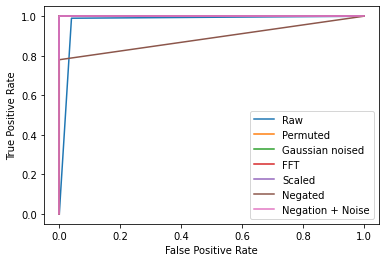

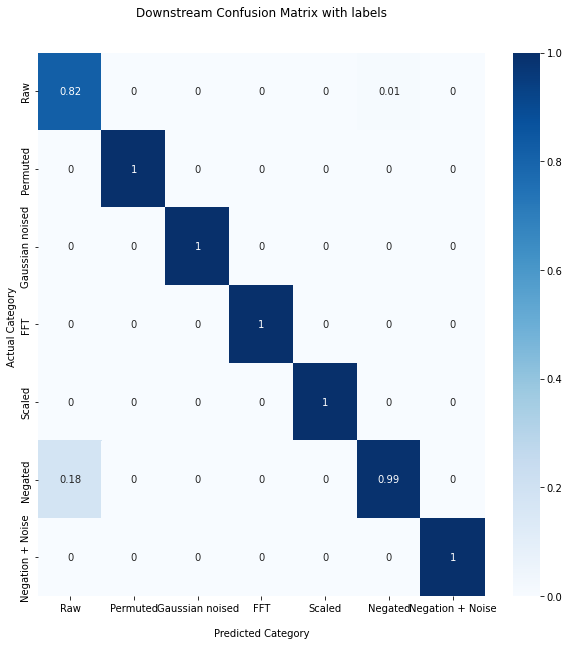

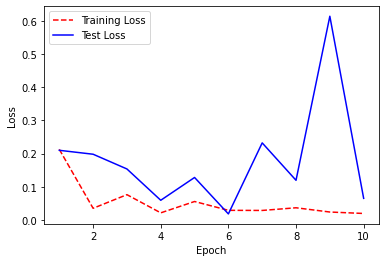

<Figure size 504x504 with 0 Axes>

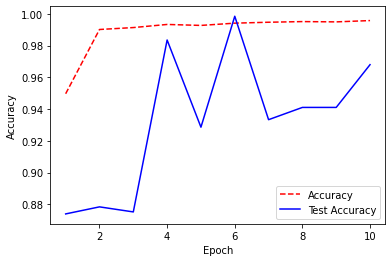

<Figure size 504x504 with 0 Axes>

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

model = Sequential()
#add model layers
model.add(Conv2D(300, kernel_size=(10,1), strides=(10, 1), activation='relu', input_shape=(x_train.shape[1], 1, 1)))
#model.add(Conv2D(300, kernel_size=(30,1), strides =(30, 1), activation='relu', input_shape=(x_train.shape[1], 1, 1)))
#model.add(MaxPooling2D(pool_size=(3,1)))
#model.add(Conv2D(300, kernel_size=(10,1)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(7, activation='softmax'))


sgd = SGD(learning_rate=0.001)
rms = RMSprop(learning_rate=0.001)
adam = Adam(learning_rate=0.001, epsilon=0.1)
model.compile(optimizer=rms,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

#model.summary()
#from keras.utils.vis_utils import plot_model
#plot_model(model, show_shapes=True, show_layer_names=True)


history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=10)

test_labels = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)
Labels = ['Raw','Permuted', 'Gaussian noised', 'FFT', 'Scaled', 'Negated', 'Negation + Noise']

printConfusionMatrix(test_labels, y_pred, Labels, show=True)

def plot_graph(x, y, z, x_label, y_label, legends, figsize=(7,7)):
  plt.plot(z, x, 'r--')
  plt.plot(z, y, 'b-')
  plt.legend(legends)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.figure(figsize=figsize)
  plt.show()

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Get training and test loss histories
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

plot_graph(training_loss, test_loss, epoch_count, 'Epoch', 'Loss', ['Training Loss', 'Test Loss'])
plot_graph(accuracy, val_accuracy, epoch_count, 'Epoch', 'Accuracy', ['Accuracy', 'Test Accuracy'])

In [8]:
data_loading_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
save_file = os.path.join(data_loading_dir, "Model.pkl")

model.save(save_file)

Extraxting the last hidden layer

In [9]:
from keras import backend as K

experience = 10
numberOfClasses = 7
data_loading_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
load_file = os.path.join(data_loading_dir, "Model.pkl")
save_file = os.path.join(data_loading_dir, "Features.pkl")

def LoadFile(data_loading_dir, file_name):
  loading_file = os.path.join(data_loading_dir, file_name + ".pkl")
  return pd.read_pickle(loading_file)

orig_dataset = LoadFile(data_loading_dir, "Raw")
raw_dataset = orig_dataset.drop(['Label'], axis=1)
permuted_dataset = LoadFile(data_loading_dir, "Permuted")
noised_dataset = LoadFile(data_loading_dir, "Noised")
fft_dataset = LoadFile(data_loading_dir, "FFT")
scaled_dataset = LoadFile(data_loading_dir, "Scaled")
negated_dataset = LoadFile(data_loading_dir, "Negated")
negation_plus_noise_dataset = LoadFile(data_loading_dir, "Negated_Plus_Noise")

model = keras.models.load_model(load_file)

def reshapeDataset(orig_dataset):
  dataset = np.array(orig_dataset)
  dataset = dataset.reshape((dataset.shape[0], dataset.shape[1], 1, 1))
  return dataset

def InsertMatrixIntoDataframe(dataframe, array):
  for i in range(array.shape[1]):
    arr = []
    for j in range(array.shape[0]):
      arr.append(array[j][i])
    dataframe[str(i)] = np.array(arr)
  print(dataframe.head(1))
  return dataframe

# with a Sequential model
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].output])

split_point = 0

dataset = reshapeDataset(raw_dataset[split_point:])
layer_output = get_3rd_layer_output([dataset])[0]

dataset = reshapeDataset(permuted_dataset[split_point:])
new_layer_output = get_3rd_layer_output([dataset])[0]
layer_output = np.append(layer_output, new_layer_output, axis=1)

dataset = reshapeDataset(noised_dataset[split_point:])
new_layer_output = get_3rd_layer_output([dataset])[0]
layer_output = np.append(layer_output, new_layer_output, axis=1)

dataset = reshapeDataset(fft_dataset[split_point:])
new_layer_output = get_3rd_layer_output([dataset])[0]
layer_output = np.append(layer_output, new_layer_output, axis=1)

dataset = reshapeDataset(scaled_dataset[split_point:])
new_layer_output = get_3rd_layer_output([dataset])[0]
layer_output = np.append(layer_output, new_layer_output, axis=1)

dataset = reshapeDataset(negated_dataset[split_point:])
new_layer_output = get_3rd_layer_output([dataset])[0]
layer_output = np.append(layer_output, new_layer_output, axis=1)

dataset = reshapeDataset(negation_plus_noise_dataset[split_point:])
new_layer_output = get_3rd_layer_output([dataset])[0]
layer_output = np.append(layer_output, new_layer_output, axis=1)

merged_features = DataFrame({'Label': orig_dataset['Label'][split_point:]})

merged_features = InsertMatrixIntoDataframe(merged_features, layer_output)

print(merged_features.shape)
merged_features.to_pickle(save_file)

<ipython-input-9-77cbe75ffb0a>:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe[str(i)] = np.array(arr)


                     Label    0    1    2    3    4    5    6    7    8  ...  \
14810  2020-02-08 11:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

       690        691       692  693  694       695  696  697  698        699  
14810  0.0  13.881373  8.680691  0.0  0.0  8.296315  0.0  0.0  0.0  43.385574  

[1 rows x 701 columns]
(14810, 701)
